### ETH Dicetion Tree

In [17]:
import pandas as pd
import numpy as np
import datetime
from cryptocmd import CmcScraper
# Plots
# ==============================================================================
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
plt.style.use('ggplot')
# Bitcoin colors
# ==============================================================================
palette_btc = {'orange': '#f7931a',
               'white' : '#ffffff',
               'gray'  : '#4d4d4d',
               'blue'  : '#0d579b',
               'green' : '#329239'
              }

# Modelling and Forecasting
# ==============================================================================
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import backtesting_forecaster
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error

%matplotlib inline

In [18]:
# Data download
# ==============================================================================

# Scraper is initialized, symbol, start and end of download are included
scraper = CmcScraper('ETH', '28-04-2021', '16-09-2023')

# Transform collected data into a dataframe
data = scraper.get_dataframe()
cdf = data
data.sort_values(by='Date', ascending=True, inplace=True)

pd.set_option('display.max_columns', None)
display(data)
pd.reset_option('display.max_columns')

,Date,Open,High,Low,Close,Volume,Market Cap
870,2021-04-28,2664.685565,2757.477348,2564.081459,2746.380053,3.426903e+10,3.176457e+11
869,2021-04-29,2748.649711,2797.972385,2672.106668,2756.876994,3.257813e+10,3.188970e+11
868,2021-04-30,2757.734115,2796.054816,2728.170023,2773.207132,2.977718e+10,3.208229e+11
867,2021-05-01,2772.838303,2951.440957,2755.908430,2945.892708,2.872621e+10,3.408404e+11
866,2021-05-02,2945.560100,2984.891882,2860.526075,2952.056055,2.803201e+10,3.415931e+11
...,...,...,...,...,...,...,...
4,2023-09-11,1616.769723,1618.305791,1533.426729,1551.637672,7.693701e+09,1.865407e+11
3,2023-09-12,1551.497800,1619.113989,1549.493727,1592.429438,6.813820e+09,1.914446e+11
2,2023-09-13,1592.892377,1615.050285,1582.217582,1607.988485,4.979469e+09,1.933161e+11
1,2023-09-14,1608.031629,1640.522745,1607.735382,1626.974326,5.538959e+09,1.955990e+11


In [19]:
# Data preparation
# ==============================================================================
data['date'] = pd.to_datetime(data['Date'], format='%Y-%m-%d %H:%M:%S')
data = data.loc[:, ['date', 'Open', 'Close', 'High', 'Low']]
data = data.rename({'Open': 'open', 'Close': 'close', 'High': 'high', 'Low': 'low'}, 
                    axis=1)
data = data.set_index('date')
data = data.asfreq('D')
data = data.sort_index()

In [20]:
# Dict with Bitcoin halvings info
# ==============================================================================
btc_halving = {'halving'              : [0, 1 , 2, 3, 4],
               'date'                 : ['2009-01-03', '2012-11-28', 
                                         '2016-07-09', '2020-05-11', np.nan],
               'reward'               : [50, 25, 12.5, 6.25, 3.125],
               'halving_block_number' : [0, 210000, 420000 ,630000, 840000]
              }

In [21]:
# Next halving calculation
# The remaining blocks according to the coinmarketcap.com website for 
# the next halving as of 2022-01-14 are taken as a starting point
# ==============================================================================
remaining_blocks = 121400
blocks_per_day = 144

days = remaining_blocks / blocks_per_day

next_halving = pd.to_datetime('2022-01-14', format='%Y-%m-%d') + datetime.timedelta(days=days)
next_halving = next_halving.replace(microsecond=0, second=0, minute=0, hour=0)
next_halving = next_halving.strftime('%Y-%m-%d')

btc_halving['date'][-1] = next_halving


In [22]:
# Include rewards and countdown to next halving in dataset
# ==============================================================================
data['reward'] = np.nan
data['countdown_halving'] = np.nan

for i in range(len(btc_halving['halving'])-1):
     
    # Start and end date of each halving
    if btc_halving['date'][i] < data.index.min().strftime('%Y-%m-%d'):
        start_date = data.index.min().strftime('%Y-%m-%d')
    else:
        start_date = btc_halving['date'][i]
        
    end_date = btc_halving['date'][i+1]
    mask = (data.index >= start_date) & (data.index < end_date)
        
    # Fill column 'reward' with mining rewards
    data.loc[mask, 'reward'] = btc_halving['reward'][i]
    
    # Fill column 'countdown_halving' with remaining days
    time_to_next_halving = pd.to_datetime(end_date) - pd.to_datetime(start_date)
    
    data.loc[mask, 'countdown_halving'] = np.arange(time_to_next_halving.days)[::-1][:mask.sum()]

In [23]:
# Check that the data have been created correctly
# ==============================================================================
print('Second halving:', btc_halving['date'][2])
display(data.loc['2016-07-08':'2016-07-09'])
print('')
print('Third halving:', btc_halving['date'][3])
display(data.loc['2020-05-10':'2020-05-11'])
print('')
print('Next halving:', btc_halving['date'][4])
data.tail(2)

Second halving: 2016-07-09


,open,close,high,low,reward,countdown_halving
date,,,,,,



Third halving: 2020-05-11


,open,close,high,low,reward,countdown_halving
date,,,,,,



Next halving: 2024-05-06


,open,close,high,low,reward,countdown_halving
date,,,,,,
2023-09-14,1608.031629,1626.974326,1640.522745,1607.735382,6.25,234.0
2023-09-15,1626.870128,1641.640344,1652.113162,1613.248674,6.25,233.0


In [24]:
# Interactive candlestick chart with Plotly
# ==============================================================================
candlestick = go.Candlestick(
                  x     = data.index,
                  open  = data.open,
                  close = data.close,
                  low   = data.low,
                  high  = data.high,
              ) 

fig = go.Figure(data=[candlestick])

fig.update_layout(
    width       = 900,
    height      = 450,
    title       = dict(text='<b>Bitcoin/USD Chart</b>', font=dict(size=30)),
    yaxis_title = dict(text='Price (USD)', font=dict(size=15)),
    margin      = dict(l=10, r=20, t=80, b=20),
    shapes      = [dict(x0=btc_halving['date'][2], x1=btc_halving['date'][2], 
                        y0=0, y1=1, xref='x', yref='paper', line_width=2),
                   dict(x0=btc_halving['date'][3], x1=btc_halving['date'][3], 
                        y0=0, y1=1, xref='x', yref='paper', line_width=2),
                   dict(x0=btc_halving['date'][4], x1=btc_halving['date'][4], 
                        y0=0, y1=1, xref='x', yref='paper', line_width=2)
                  ],
    annotations = [dict(x=btc_halving['date'][2], y=1, xref='x', yref='paper',
                      showarrow=False, xanchor='left', text='Second halving'),
                   dict(x=btc_halving['date'][3], y=1, xref='x', yref='paper',
                      showarrow=False, xanchor='left', text='Third halving'),
                   dict(x=btc_halving['date'][4], y=1, xref='x', yref='paper',
                      showarrow=False, xanchor='left', text='Fourth halving')
                  ],
    xaxis_rangeslider_visible = False,
)

fig.show()

In [25]:
#print(cdf.head())

#X = np.asarray(cdf[['Date','Open','High','Low','Volume','Market Cap']])
#y = np.asarray(cdf[['Close']])

X = cdf[['Date','Open','High','Low','Volume','Market Cap']]

Date_time = np.asarray(X[['Date']])

#print(Date_time)
normal_time = []

for i in Date_time:
    item = str(i)
    tival = [int(item[2:6:]) ,  int(item[7:9:]) , int(item[10:12:])]
    normal_time.append(tival)

print(normal_time)
print(normal_time[0])
print(normal_time[-1])

import datetime

d1 = datetime.date(normal_time[0][0], normal_time[0][1], normal_time[0][2])
d2 = datetime.date(normal_time[-1][0], normal_time[-1][1], normal_time[-1][2])
x_days = int((d2 - d1).days + 1)

date_data = np.arange(x_days)
print(date_data)

cdf = cdf.drop('Date', axis=1)
cdf['Date'] = np.array(date_data)

columns_titles = ['Date','Open','High','Low','Close','Volume','Market Cap']
cdf=cdf.reindex(columns=columns_titles)

print(cdf.head())

[[2021, 4, 28], [2021, 4, 29], [2021, 4, 30], [2021, 5, 1], [2021, 5, 2], [2021, 5, 3], [2021, 5, 4], [2021, 5, 5], [2021, 5, 6], [2021, 5, 7], [2021, 5, 8], [2021, 5, 9], [2021, 5, 10], [2021, 5, 11], [2021, 5, 12], [2021, 5, 13], [2021, 5, 14], [2021, 5, 15], [2021, 5, 16], [2021, 5, 17], [2021, 5, 18], [2021, 5, 19], [2021, 5, 20], [2021, 5, 21], [2021, 5, 22], [2021, 5, 23], [2021, 5, 24], [2021, 5, 25], [2021, 5, 26], [2021, 5, 27], [2021, 5, 28], [2021, 5, 29], [2021, 5, 30], [2021, 5, 31], [2021, 6, 1], [2021, 6, 2], [2021, 6, 3], [2021, 6, 4], [2021, 6, 5], [2021, 6, 6], [2021, 6, 7], [2021, 6, 8], [2021, 6, 9], [2021, 6, 10], [2021, 6, 11], [2021, 6, 12], [2021, 6, 13], [2021, 6, 14], [2021, 6, 15], [2021, 6, 16], [2021, 6, 17], [2021, 6, 18], [2021, 6, 19], [2021, 6, 20], [2021, 6, 21], [2021, 6, 22], [2021, 6, 23], [2021, 6, 24], [2021, 6, 25], [2021, 6, 26], [2021, 6, 27], [2021, 6, 28], [2021, 6, 29], [2021, 6, 30], [2021, 7, 1], [2021, 7, 2], [2021, 7, 3], [2021, 7, 4], [

In [26]:
#print(cdf[['Open']])
#print(cdf[['Close']])
#print(cdf.head())

In [27]:
close_data = np.asarray(cdf[['Close']]).astype('float')
open_data = np.asarray(cdf[['Open']]).astype('float')

Cross = []

for n , i in enumerate(open_data):
    if int(open_data[n]) >= int(close_data[n]):
        res = 0
    else :
        res = 1
    Cross.append(res)

cdf['Cross'] = np.array(Cross)

print(cdf.head())

     Date         Open         High          Low        Close        Volume  \
870     0  2664.685565  2757.477348  2564.081459  2746.380053  3.426903e+10   
869     1  2748.649711  2797.972385  2672.106668  2756.876994  3.257813e+10   
868     2  2757.734115  2796.054816  2728.170023  2773.207132  2.977718e+10   
867     3  2772.838303  2951.440957  2755.908430  2945.892708  2.872621e+10   
866     4  2945.560100  2984.891882  2860.526075  2952.056055  2.803201e+10   

       Market Cap  Cross  
870  3.176457e+11      1  
869  3.188970e+11      1  
868  3.208229e+11      1  
867  3.408404e+11      1  
866  3.415931e+11      1  


In [28]:
x_data = np.asarray(cdf[['Date','Open','Close','High','Low','Volume','Market Cap']])
y_data = np.asarray(cdf[['Cross']])

In [29]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( x_data, y_data, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (696, 7) (696, 1)
Test set: (175, 7) (175, 1)


In [30]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import jaccard_score

In [31]:
def best_tree_deep(X_train,y_train,y_test,max_deep):
    """criterion{“gini”, “entropy”, }, default=“gini”
        splitter{“best”, “random”}, default=”best”
        max_depth, default=None
        max_features, float or {“auto”, “sqrt”, “log2”}, default=None
        """
    gold_method=[]
    for x in range(1,10):
        #Entropy
        entropy_f1_deep = [] 
        #entropy best
        for i in range(1,max_deep):
            dictree = DecisionTreeClassifier(criterion="entropy",splitter="best", max_depth = i)
            dictree.fit(X_train,y_train)
            predTree = dictree.predict(X_test)
            f1 = f1_score(y_test, predTree) 
            item = [f1  , i , "entropy" , 'best' , "none", predTree]
            entropy_f1_deep.append(item)
        
        for i in range(1,max_deep):
            dictree = DecisionTreeClassifier(criterion="entropy",splitter="best",max_features="auto", max_depth = i)
            dictree.fit(X_train,y_train)
            predTree = dictree.predict(X_test)
            f1 = f1_score(y_test, predTree) 
            item = [f1  , i , "entropy" , 'best' , 'auto', predTree]
            entropy_f1_deep.append(item)
        
        for i in range(1,max_deep):
            dictree = DecisionTreeClassifier(criterion="entropy",splitter="best",max_features="sqrt", max_depth = i)
            dictree.fit(X_train,y_train)
            predTree = dictree.predict(X_test)
            f1 = f1_score(y_test, predTree) 
            item = [f1 , i , "entropy" , 'best', 'sqrt', predTree]
            entropy_f1_deep.append(item)
        
        for i in range(1,max_deep):
            dictree = DecisionTreeClassifier(criterion="entropy",splitter="best",max_features="log2", max_depth = i)
            dictree.fit(X_train,y_train)
            predTree = dictree.predict(X_test)
            f1 = f1_score(y_test, predTree) 
            item = [f1  , i , "entropy" , 'best' , 'log2', predTree]
            entropy_f1_deep.append(item)

        #entropy random
        for i in range(1,max_deep):
            dictree = DecisionTreeClassifier(criterion="entropy",splitter="random", max_depth = i)
            dictree.fit(X_train,y_train)
            predTree = dictree.predict(X_test)
            f1 = f1_score(y_test, predTree) 
            item = [f1 , i , "entropy" , 'random', "none", predTree]
            entropy_f1_deep.append(item)
        
        for i in range(1,max_deep):
            dictree = DecisionTreeClassifier(criterion="entropy",splitter="random",max_features="auto", max_depth = i)
            dictree.fit(X_train,y_train)
            predTree = dictree.predict(X_test)
            f1 = f1_score(y_test, predTree) 
            item = [f1 , i , "entropy" , 'random', 'auto', predTree]
            entropy_f1_deep.append(item)
        
        for i in range(1,max_deep):
            dictree = DecisionTreeClassifier(criterion="entropy",splitter="random",max_features="sqrt", max_depth = i)
            dictree.fit(X_train,y_train)
            predTree = dictree.predict(X_test)
            f1 = f1_score(y_test, predTree) 
            item = [f1 , i , "entropy" , 'random', 'sqrt', predTree]
            entropy_f1_deep.append(item)

        for i in range(1,max_deep):
            dictree = DecisionTreeClassifier(criterion="entropy",splitter="random",max_features="log2", max_depth = i)
            dictree.fit(X_train,y_train)
            predTree = dictree.predict(X_test)
            f1 = f1_score(y_test, predTree) 
            item = [f1 , i , "entropy" , 'random', 'log2', predTree]
            entropy_f1_deep.append(item)

        # GINI
        gini_f1_deep = [] 
        #gini best
        for i in range(1,max_deep):
            dictree = DecisionTreeClassifier(criterion="gini",splitter="best", max_depth = i)
            dictree.fit(X_train,y_train)
            predTree = dictree.predict(X_test)
            f1 = f1_score(y_test, predTree) 
            item = [f1 , i , "gini" , 'best' , "none", predTree]
            gini_f1_deep.append(item)
        
        for i in range(1,max_deep):
            dictree = DecisionTreeClassifier(criterion="gini",splitter="best",max_features="auto", max_depth = i)
            dictree.fit(X_train,y_train)
            predTree = dictree.predict(X_test)
            f1 = f1_score(y_test, predTree) 
            item = [f1, i , "gini" , 'best' , 'auto', predTree]
            gini_f1_deep.append(item)
        
        for i in range(1,max_deep):
            dictree = DecisionTreeClassifier(criterion="gini",splitter="best",max_features="sqrt", max_depth = i)
            dictree.fit(X_train,y_train)
            predTree = dictree.predict(X_test)
            f1 = f1_score(y_test, predTree) 
            item = [f1, i , "gini" , 'best', 'sqrt', predTree]
            gini_f1_deep.append(item)
        
        for i in range(1,max_deep):
            dictree = DecisionTreeClassifier(criterion="gini",splitter="best",max_features="log2", max_depth = i)
            dictree.fit(X_train,y_train)
            predTree = dictree.predict(X_test)
            f1 = f1_score(y_test, predTree) 
            item = [f1 , i , "gini" , 'best' , 'log2', predTree]
            gini_f1_deep.append(item)

        #gini random
        for i in range(1,max_deep):
            dictree = DecisionTreeClassifier(criterion="gini",splitter="random", max_depth = i)
            dictree.fit(X_train,y_train)
            predTree = dictree.predict(X_test)
            f1 = f1_score(y_test, predTree) 
            item = [f1 , i , "gini" , 'random',"none", predTree]
            gini_f1_deep.append(item)
        
        for i in range(1,max_deep):
            dictree = DecisionTreeClassifier(criterion="gini",splitter="random",max_features="auto", max_depth = i)
            dictree.fit(X_train,y_train)
            predTree = dictree.predict(X_test)
            f1 = f1_score(y_test, predTree) 
            item = [f1 , i , "gini" , 'random', 'auto', predTree]
            gini_f1_deep.append(item)
        
        for i in range(1,max_deep):
            dictree = DecisionTreeClassifier(criterion="gini",splitter="random",max_features="sqrt", max_depth = i)
            dictree.fit(X_train,y_train)
            predTree = dictree.predict(X_test)
            f1 = f1_score(y_test, predTree) 
            item = [f1 , i , "gini" , 'random', 'sqrt', predTree]
            gini_f1_deep.append(item)

        for i in range(1,max_deep):
            dictree = DecisionTreeClassifier(criterion="gini",splitter="random",max_features="log2", max_depth = i)
            dictree.fit(X_train,y_train)
            predTree = dictree.predict(X_test)
            f1 = f1_score(y_test, predTree) 
            item = [f1 , i , "gini" , 'random', 'log2', predTree]
            gini_f1_deep.append(item)
        
        best_deep_method = [max(gini_f1_deep),max(entropy_f1_deep)]
        gold_method.append(max(best_deep_method))

    print(gold_method)
    gold = max(gold_method)

    return(gold)

In [32]:
BTD = best_tree_deep(X_train,y_train,y_test,10)
f1 = f1_score(y_test, BTD[5]) 
js = jaccard_score(y_test,BTD[5])

DecisionTree = [f1 , js] 
print('DecisionTree F1 score : ' +  str(DecisionTree[0]) , '\n' + 'DecisionTree Jaccard score : ' + str(DecisionTree[1]))

[[0.7446808510638298, 7, 'gini', 'random', 'none', array([1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0,
       1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0,
       1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0,
       0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1,
       0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0,
       1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1])], [0.7363636363636363, 8, 'entropy', 'random', 'none', array([1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1,
       0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0,
       1, 1, 0, 0, 1

In [33]:
if BTD[4] != 'none':
    dictree = DecisionTreeClassifier(criterion=BTD[2],splitter=BTD[3],max_features=BTD[4], max_depth = BTD[1])
else:
    dictree = DecisionTreeClassifier(criterion=BTD[2],splitter=BTD[3], max_depth = BTD[1])

dictree.fit(X_train,y_train)
predTree = BTD[5]

In [34]:
from  io import StringIO
import pydotplus
import matplotlib.image as mpimg
from sklearn import tree
%matplotlib inline 

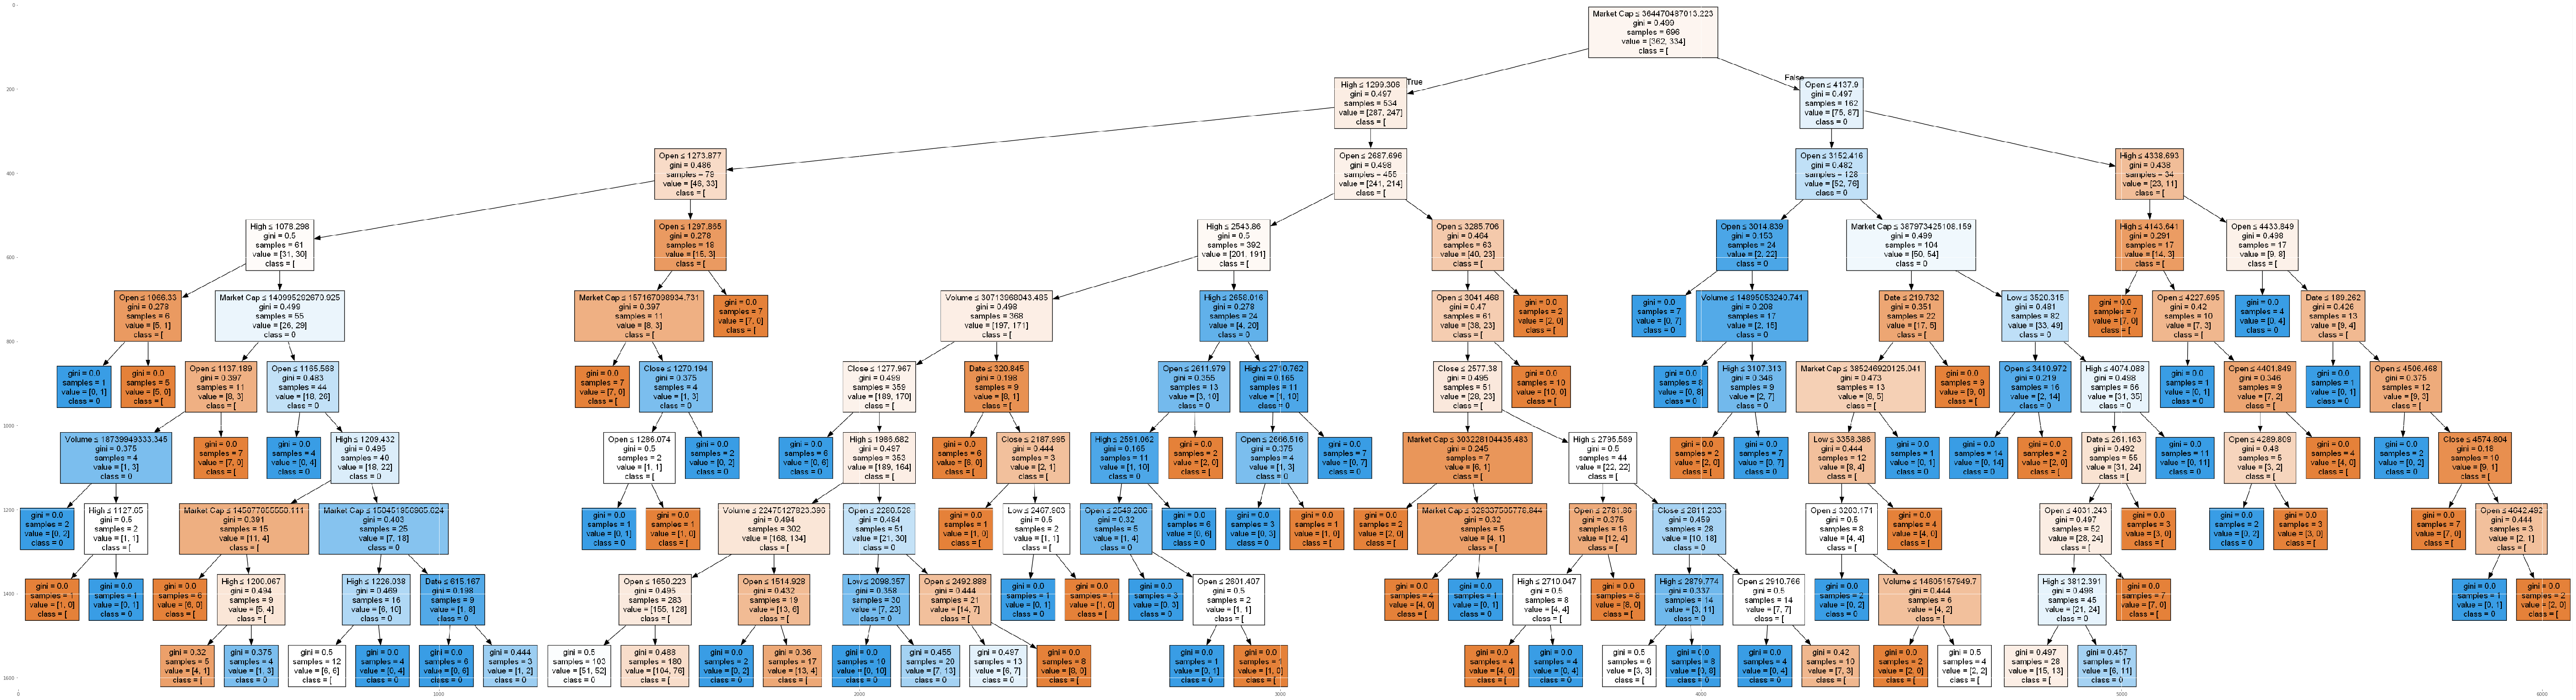

In [35]:
dot_data = StringIO()
filename = "drugtree.png"
featureNames = cdf.columns[0:7]

out=tree.export_graphviz(
    dictree,feature_names=featureNames,
    out_file=dot_data,
    class_names= str(np.unique(y_train)),
    filled=True,
    special_characters=True,
    rotate=False)  

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  

graph.write_png(filename)
img = mpimg.imread(filename)
plt.figure(figsize=(100, 200))
plt.imshow(img,interpolation='nearest')

In [36]:
BTD[5]
print(BTD[5])

[1 0 0 1 1 0 0 1 1 0 0 1 0 0 0 0 0 0 1 1 1 0 0 1 0 0 1 0 1 1 1 1 1 1 1 0 0
 1 1 1 0 1 1 1 1 1 0 1 1 1 0 0 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 0 1 1 0 1
 0 1 1 1 1 0 1 1 1 1 0 1 1 0 1 1 0 0 0 1 1 0 1 1 0 0 0 0 1 0 1 1 1 0 1 1 0
 0 0 1 1 1 0 0 1 1 0 1 1 0 0 0 0 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1
 1 0 0 0 0 1 1 0 1 1 1 1 1 1 1 1 1 0 1 0 1 1 0 0 0 1 0]
